In [91]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [92]:
# LSTM_Live 폴더의 모든 CSV 파일 병합
def LSTM_Live_Merge(folder_path):
    
    csv_files = []

    # 하위 폴더까지 탐색
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.csv'):
                csv_path = os.path.join(root, file)
                
                # CSV 불러오기
                df = pd.read_csv(csv_path)
                csv_files.append(df)

    # 모든 CSV 파일 병합
    if csv_files:
        combined_df = pd.concat(csv_files, ignore_index=True)
        print(f"총 {len(csv_files)}개의 CSV 파일을 병합했습니다. 데이터 크기: {combined_df.shape}")
        return combined_df
    else:
        print("병합할 CSV 파일이 없습니다.")
        return pd.DataFrame()


In [93]:
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

# 폴더 내 CSV 파일 병합
def LSTM_Capture_Merge(folder_path, sequence):
    
    csv_files = []

    for root, _, files in sorted(os.walk(folder_path), key=lambda x: natural_sort_key(x[0])):
        sorted_files = sorted([file for file in files if file.endswith('.csv')], key=natural_sort_key)
        file_count = len(sorted_files)
        
        if file_count == 0:
            continue  # CSV 파일이 없는 폴더는 건너뜀
        
        if file_count % sequence != 0:
            print(f"[제외] {root}: CSV 파일 수 {file_count}개는 {sequence}의 배수가 아닙니다.")
            continue  # sequence의 배수가 아니면 병합 제외

        for file in sorted_files:
            csv_path = os.path.join(root, file)
            csv_files.append(csv_path)

    if not csv_files:
        print("병합할 CSV 파일이 없습니다.")
        return pd.DataFrame()
    
    # CSV 파일 병합 (float_precision 추가)
    dataframes = [pd.read_csv(file, float_precision='round_trip') for file in csv_files]
    combined_df = pd.concat(dataframes, ignore_index=True)
    print(f"총 {len(csv_files)}개의 CSV 파일을 병합했습니다. 데이터 크기: {combined_df.shape}")
    return combined_df

In [94]:
# 데이터 시퀀스별로 변환
def reshape_to_sequences(data, labels, seq_length):
    sequences = []
    sequence_labels = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:i + seq_length])
        sequence_labels.append(labels[i + seq_length - 1])  # 시퀀스의 마지막 레이블 사용
    return np.array(sequences), np.array(sequence_labels)

In [97]:
# 클래스 균등하게 정리
def balance_classes(df, class_column, target_samples):

    # 그룹화하여 각 클래스에서 샘플링
    balanced_df = df.groupby(class_column).apply(
        lambda x: x.sample(n=target_samples, random_state=42) if len(x) >= target_samples else x
    )
    
    # 인덱스 초기화
    balanced_df = balanced_df.reset_index(drop=True)
    return balanced_df

In [101]:
# 데이터 불러오기 및 병합
folder_path = './Data'  # 데이터 폴더 경로
df_live = LSTM_Live_Merge(folder_path + '/LSTM_Live') # LSTM_Live 폴더 병합
df_capture = LSTM_Capture_Merge(folder_path + '/LSTM_Capture', sequence=3) # LSTM_Capture 폴더 병합
df= pd.concat([df_live, df_capture], ignore_index=True) # 전체 폴더 병합

병합할 CSV 파일이 없습니다.
총 3702개의 CSV 파일을 병합했습니다. 데이터 크기: (3702, 35)


In [102]:
# 정리 전 클래스별 갯수 확인
print(df['action_class'].value_counts())

action_class
0    3051
1     336
2     126
3     105
4      84
Name: count, dtype: int64


In [103]:
# 클래스 균등하게 정리
df = balance_classes(df, class_column='action_class', target_samples=126)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_41392\2504395227.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(class_column).apply(


In [104]:
# 데이터프레임 확인
print(df['action_class'].value_counts())
df

action_class
0    126
1    126
2    126
3    105
4     84
Name: count, dtype: int64


,kp0_x,kp0_y,kp1_x,kp1_y,kp2_x,kp2_y,kp3_x,kp3_y,kp4_x,kp4_y,...,kp12_y,kp13_x,kp13_y,kp14_x,kp14_y,kp15_x,kp15_y,kp16_x,kp16_y,action_class
0,270.644043,98.446548,273.991882,95.654221,267.979370,94.232727,0.000000,0.000000,258.058289,87.380455,...,144.642242,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,197.262924,71.575928,198.394913,70.360977,196.678955,70.761635,201.921509,70.420486,0.000000,0.000000,...,100.137642,209.554565,115.216171,196.896378,117.181976,210.245483,131.477020,197.447998,133.056412,0
2,161.233276,54.908836,162.531403,52.925133,159.984970,53.843803,167.201080,52.855110,0.000000,0.000000,...,87.797180,182.101379,104.689667,176.904480,105.624474,185.710327,122.186707,183.632935,119.477089,0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,150.798325,276.412354,159.807983,282.822693,160.209671,274.824707,169.956436,281.300232,170.647385,0
4,198.769669,60.223045,199.590622,58.928230,197.391144,59.166946,0.000000,0.000000,195.238739,59.581139,...,88.449585,208.854584,103.203575,198.051407,105.543419,210.987000,117.458099,198.947708,120.643379,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562,390.292511,165.254135,399.619995,154.331985,378.587708,158.592682,419.849670,150.174194,368.184296,159.793457,...,312.955688,429.174927,365.112518,397.687988,394.607147,415.995819,419.354553,388.657440,454.828094,4
563,416.143738,155.864273,417.986725,144.564911,401.367188,151.310699,0.000000,0.000000,375.780701,161.888550,...,318.581451,429.225037,366.078461,396.260193,395.227356,412.993744,424.688660,388.216187,454.038788,4
564,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,384.757904,168.247681,...,322.249084,430.079834,367.219666,394.837341,393.478668,413.349854,423.541748,389.750397,451.897827,4
565,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,386.309235,170.316528,...,323.810455,430.822449,368.328613,395.818085,395.790497,413.806061,423.343231,390.579102,453.736694,4


In [105]:
# X, y 분리
X = df.iloc[:, :-1].values # 키포인트
y = df.iloc[:, -1].values # 클래스

In [106]:
# 레이블 원-핫 인코딩
y = to_categorical(y)

In [107]:
# 데이터 시퀀스 길이 지정
seq_length = 3  # 시퀀스 길이

# 데이터를 시퀀스 형태로 변환
X_seq, y_seq = reshape_to_sequences(X, y, seq_length)

In [108]:
# 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [109]:
# LSTM 모델 정의
model = Sequential([
    LSTM(128, input_shape=(seq_length, X_train.shape[2]), return_sequences=True),
    LSTM(64),
    Dense(32, activation="relu"),
    Dense(y_train.shape[1], activation="softmax")
    ])

c:\Users\User\anaconda3\envs\action_recognition\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [111]:
 # 모델 컴파일 및 학습
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
es = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 20, mode = 'auto', restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=300, batch_size=32, callbacks=es).history

Epoch 1/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.7581 - loss: 0.7356 - val_accuracy: 0.7965 - val_loss: 0.6481
Epoch 2/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8424 - loss: 0.5679 - val_accuracy: 0.8230 - val_loss: 0.5408
Epoch 3/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8105 - loss: 0.5533 - val_accuracy: 0.7965 - val_loss: 0.5518
Epoch 4/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8414 - loss: 0.4726 - val_accuracy: 0.8230 - val_loss: 0.5367
Epoch 5/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8733 - loss: 0.3660 - val_accuracy: 0.8053 - val_loss: 0.4751
Epoch 6/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9070 - loss: 0.3040 - val_accuracy: 0.8496 - val_loss: 0.4847
Epoch 7/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9075 - loss: 0.3065 - val_accuracy: 0.8142 - val_loss: 0.5220
Epoch 8/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9316 - loss: 0.2821 - val_accuracy: 0.

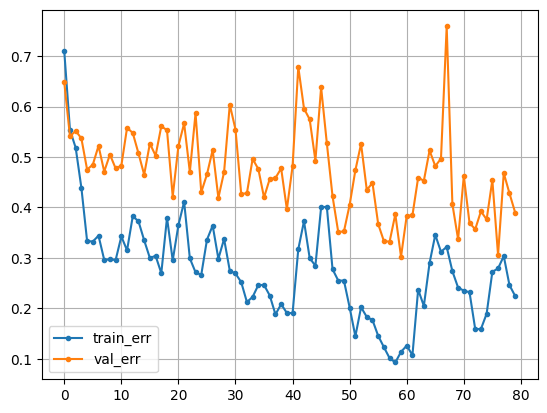

In [112]:
plt.plot(history['loss'], label = 'train_err', marker = '.')
plt.plot(history['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

In [113]:
# 모델 저장
output_model = './Model/LSTM.h5'
model.save(output_model)

In [114]:
# 학습된 모델 평가
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"검증 데이터 정확도: {accuracy * 100:.2f}%")

검증 데이터 정확도: 92.04%
